In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.5 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import torch
import plotly.graph_objs as go
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Train Loss: 0.6453, Train Accuracy: 0.5891
Epoch 1, Test Loss: 0.6103, Test Accuracy: 0.6305
Epoch 2, Train Loss: 0.5855, Train Accuracy: 0.6650
Epoch 2, Test Loss: 0.5712, Test Accuracy: 0.6745
Final Test Accuracy: 0.6745
F1 Score: 0.7484
Recall: 0.8157
Precision: 0.6913
Specificity: 0.4686
AUC-ROC: 0.6421


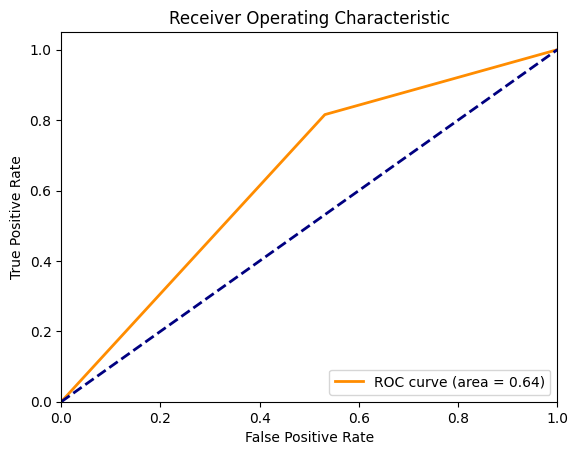

In [6]:
"""import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Dataset, Data
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define joints and edges
joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]

edges = [
    ('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
    ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
    ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
    ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
    ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
    ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
    ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
    ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
    ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
    ('HEAD', 'NOSE'),('HEAD','EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')
]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}

edge_index = torch.tensor(
    [[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
    [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],  # Bidirectional edges
    dtype=torch.long
).t()

# Custom Dataset Class
class SkeletonDataset(Dataset):
    def __init__(self, csv_file):
        self.data = csv_file
        self.num_nodes = len(joints)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Extract node features and include timestamp
        node_features = []
        for joint in joints:
            x = row[f'{joint}_X']
            y = row[f'{joint}_Y']
            z = row[f'{joint}_Z']
            timestamp = row['timeStamps']  # Include timestamp as a feature
            node_features.append([x, y, z, timestamp])

        x = torch.tensor(node_features, dtype=torch.float)  # Shape: [num_nodes, 4]

        # Label
        y = torch.tensor(row['frailty_class'], dtype=torch.float)

        # Create data object
        data = Data(x=x, edge_index=edge_index, y=y)

        return data

# Hybrid STGCN Model Definition
class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(HybridSTGCN, self).__init__()

        # Spatial Graph Convolution Layers
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        # Temporal Convolution Layers
        self.temporal_conv1 = nn.Conv1d(in_channels=hidden_channels,
                                        out_channels=hidden_channels,
                                        kernel_size=3, padding=1)

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch  # x: [num_nodes*batch_size, in_channels]

        # Spatial GCN Layers
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))  # x: [num_nodes*batch_size, hidden_channels]

        # Reshape for Temporal Conv
        batch_size = batch.max().item() + 1
        num_nodes = x.size(0) // batch_size
        x = x.view(batch_size, num_nodes, -1)  # [batch_size, num_nodes, hidden_channels]
        x = x.permute(0, 2, 1)  # [batch_size, hidden_channels, num_nodes]

        # Temporal Conv Layer
        x = F.relu(self.temporal_conv1(x))  # [batch_size, hidden_channels, num_nodes]

        # LSTM for capturing temporal patterns
        x = x.permute(0, 2, 1)  # [batch_size, num_nodes, hidden_channels]
        x, _ = self.lstm(x)  # [batch_size, num_nodes, hidden_channels]

        # Pooling over nodes
        x = x.mean(dim=1)  # [batch_size, hidden_channels]

        # Fully Connected Layer
        x = self.fc(x)  # [batch_size, num_classes]
        x = torch.sigmoid(x)  # For binary classification

        return x.squeeze()  # [batch_size]

data_path = '/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/Final_data_Balanced.csv'


dataframe = pd.read_csv(data_path)


# Load dataset
dataset = SkeletonDataset(csv_file=dataframe[dataframe['walking_speed'] == "Fast"])


# Split into training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])



# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



# Training Function
def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # [batch_size]
        y = data.y.to(device).float()  # [batch_size]

        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        preds = (out >= 0.5).float()
        correct += (preds == y).sum().item()
        total += data.num_graphs

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / total
    print(f'Epoch {epoch}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy



# Evaluation Function
def evaluate(loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).view(-1)  # Ensure the output is of shape [batch_size]
            y = data.y.to(device).float().view(-1)  # Ensure target is of shape [batch_size]
            preds = (out >= 0.5).float()

            total_loss += criterion(out, y.float()).item() * data.num_graphs
            correct += (preds == y).sum().item()
            total += data.num_graphs
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy, all_preds, all_labels


# Training Loop
num_epochs = 2
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    # Train the model and get training loss and accuracy
    train_loss, train_acc = train(epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate the model on the test set and get test loss and accuracy
    test_loss, test_acc, all_preds, all_labels = evaluate(test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Final Evaluation Metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_preds)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

print(f'Final Test Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_preds)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

"""

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Train Loss: 0.6341, Train Accuracy: 0.6028
Epoch 1, Test Loss: 0.5934, Test Accuracy: 0.6774
Epoch 2, Train Loss: 0.5719, Train Accuracy: 0.6787
Epoch 2, Test Loss: 0.5469, Test Accuracy: 0.7163
Epoch 3, Train Loss: 0.5407, Train Accuracy: 0.7048
Epoch 3, Test Loss: 0.5235, Test Accuracy: 0.7282
Epoch 4, Train Loss: 0.5178, Train Accuracy: 0.7338
Epoch 4, Test Loss: 0.4970, Test Accuracy: 0.7589
Epoch 5, Train Loss: 0.4914, Train Accuracy: 0.7576
Epoch 5, Test Loss: 0.4801, Test Accuracy: 0.7765
Epoch 6, Train Loss: 0.4650, Train Accuracy: 0.7779
Epoch 6, Test Loss: 0.4474, Test Accuracy: 0.7910
Epoch 7, Train Loss: 0.4396, Train Accuracy: 0.7929
Epoch 7, Test Loss: 0.4119, Test Accuracy: 0.8185
Final Test Accuracy: 0.8185
F1 Score: 0.8437
Recall: 0.8414
Precision: 0.8459
Specificity: 0.7867
AUC-ROC: 0.8140


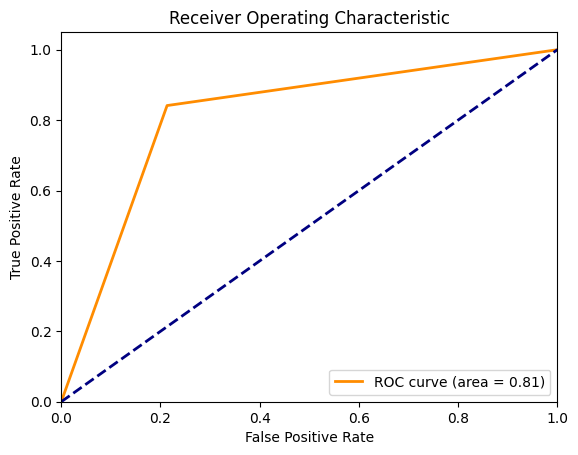

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Dataset, Data
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define joints and edges
joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]

edges = [
    ('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
    ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
    ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
    ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
    ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
    ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
    ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
    ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
    ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
    ('HEAD', 'NOSE'),('HEAD','EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')
]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}

edge_index = torch.tensor(
    [[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
    [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],  # Bidirectional edges
    dtype=torch.long
).t()

# Custom Dataset Class
class SkeletonDataset(Dataset):
    def __init__(self, csv_file):
        self.data = csv_file
        self.num_nodes = len(joints)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Extract node features and include timestamp
        node_features = []
        for joint in joints:
            x = row[f'{joint}_X']
            y = row[f'{joint}_Y']
            z = row[f'{joint}_Z']
            timestamp = row['timeStamps']  # Include timestamp as a feature
            node_features.append([x, y, z, timestamp])

        x = torch.tensor(node_features, dtype=torch.float)  # Shape: [num_nodes, 4]

        # Label
        y = torch.tensor(row['frailty_class'], dtype=torch.float)

        # Create data object
        data = Data(x=x, edge_index=edge_index, y=y)

        return data

class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(HybridSTGCN, self).__init__()

        # Spatial Graph Convolution Layers
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        # Temporal Convolution Layers
        self.temporal_conv1 = nn.Conv1d(in_channels=hidden_channels,
                                        out_channels=hidden_channels,
                                        kernel_size=3, padding=1)

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_channels, num_classes)

        # To store the feature maps
        self.feature_maps = None

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch  # x: [num_nodes*batch_size, in_channels]

        # Spatial GCN Layers
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))

        # Store the feature maps
        self.feature_maps = x  # Store the output of the last GCN layer

        # Reshape for Temporal Conv
        batch_size = batch.max().item() + 1
        num_nodes = x.size(0) // batch_size
        x = x.view(batch_size, num_nodes, -1)  # [batch_size, num_nodes, hidden_channels]
        x = x.permute(0, 2, 1)  # [batch_size, hidden_channels, num_nodes]

        # Temporal Conv Layer
        x = F.relu(self.temporal_conv1(x))  # [batch_size, hidden_channels, num_nodes]

        # LSTM for capturing temporal patterns
        x = x.permute(0, 2, 1)  # [batch_size, num_nodes, hidden_channels]
        x, _ = self.lstm(x)  # [batch_size, num_nodes, hidden_channels]

        # Pooling over nodes
        x = x.mean(dim=1)  # [batch_size, hidden_channels]

        # Fully Connected Layer
        x = self.fc(x)  # [batch_size, num_classes]
        x = torch.sigmoid(x)  # For binary classification

        return x.squeeze()  # [batch_size]




data_path = '/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/Final_data_Balanced.csv'


dataframe = pd.read_csv(data_path)


# Load dataset
dataset = SkeletonDataset(csv_file=dataframe[dataframe['walking_speed'] == "Fast"])


# Split into training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])



# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



# Training Function
def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # [batch_size]
        y = data.y.to(device).float()  # [batch_size]

        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        preds = (out >= 0.5).float()
        correct += (preds == y).sum().item()
        total += data.num_graphs

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / total
    print(f'Epoch {epoch}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy



# Evaluation Function
def evaluate(loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).view(-1)  # Ensure the output is of shape [batch_size]
            y = data.y.to(device).float().view(-1)  # Ensure target is of shape [batch_size]
            preds = (out >= 0.5).float()

            total_loss += criterion(out, y.float()).item() * data.num_graphs
            correct += (preds == y).sum().item()
            total += data.num_graphs
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy, all_preds, all_labels


# Training Loop
num_epochs = 7
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    # Train the model and get training loss and accuracy
    train_loss, train_acc = train(epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate the model on the test set and get test loss and accuracy
    test_loss, test_acc, all_preds, all_labels = evaluate(test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Final Evaluation Metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_preds)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

print(f'Final Test Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_preds)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [8]:
import torch
import torch.nn.functional as F
import plotly.graph_objs as go



def generate_grad_cam(model, data):
    model.eval()

    # Forward pass with hook
    def forward_hook(module, input, output):
        model.feature_maps = output
        output.retain_grad()

    # Register hook to the last convolutional layer (temporal_conv1)
    handle = model.temporal_conv1.register_forward_hook(forward_hook)

    # Perform forward pass
    output = model(data)

    # Zero gradients
    model.zero_grad()

    # Backward pass for the output (assuming binary classification)
    output.backward(torch.ones_like(output))

    # Get gradients and feature maps
    gradients = model.feature_maps.grad  # Gradients with respect to feature maps
    feature_maps = model.feature_maps

    # Remove the hook
    handle.remove()

    # Pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2])  # Shape: [hidden_channels]

    # Weight the feature maps by the pooled gradients
    for i in range(pooled_gradients.size(0)):
        feature_maps[:, i, :] *= pooled_gradients[i]

    # Average the feature maps across the channels to get the heatmap
    heatmap = torch.mean(feature_maps, dim=1).squeeze()

    # ReLU activation and normalization
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)

    return heatmap


In [9]:
def visualize_grad_cam(heatmap, data):
    # Detach the heatmap from the graph and convert to numpy
    heatmap = heatmap.detach().cpu().numpy()

    # Extract joint positions (x, y, z) from the data
    x_coords = data.x[:, 0].cpu().numpy()  # X coordinates
    y_coords = data.x[:, 1].cpu().numpy()  # Y coordinates
    z_coords = data.x[:, 2].cpu().numpy()  # Z coordinates

    # Create a 3D scatter plot of the skeleton with heatmap coloring
    node_trace = go.Scatter3d(
        x=x_coords,
        y=y_coords,
        z=z_coords,
        mode='markers',
        marker=dict(
            size=5,
            color=heatmap,  # Color by heatmap intensity
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(thickness=10, title='Importance'),
        ),
    )

    # Create edges for the skeleton
    edge_x = []
    edge_y = []
    edge_z = []
    for edge in edge_index.t().tolist():
        x0, y0, z0 = data.x[edge[0], :3].cpu().numpy()  # Use only the first 3 features (x, y, z)
        x1, y1, z1 = data.x[edge[1], :3].cpu().numpy()  # Use only the first 3 features (x, y, z)
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])

    edge_trace = go.Scatter3d(
        x=edge_x,
        y=edge_y,
        z=edge_z,
        mode='lines',
        line=dict(color='black', width=2),
        hoverinfo='none'
    )

    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        title='Grad-CAM Visualization on Skeleton',
        showlegend=False,
        scene=dict(
            xaxis=dict(showbackground=False),
            yaxis=dict(showbackground=False),
            zaxis=dict(showbackground=False),
        )
    )
    fig.show()


# 047-MW

In [10]:
# Step 1: Filter data for the specific patientID
target_patient_id = '047-MW'  # Replace with the actual patientID
patient_data = dataframe[dataframe['patientID'] == target_patient_id]

# Step 2: Load into dataset and DataLoader
patient_dataset = SkeletonDataset(csv_file=patient_data)
patient_loader = DataLoader(patient_dataset, batch_size=1, shuffle=False)

# Step 3: Pass through model and generate Grad-CAM
patient_data_example = next(iter(patient_loader))
patient_data_example = patient_data_example.to(device)

heatmap = generate_grad_cam(model, patient_data_example)

# Step 4: Visualize the explanation
visualize_grad_cam(heatmap[0], patient_data_example)


In [11]:
visualize_grad_cam(heatmap[1], patient_data_example)

In [14]:
visualize_grad_cam(heatmap[2], patient_data_example)

In [15]:
visualize_grad_cam(heatmap[3], patient_data_example)

In [ ]:
data_example = next(iter(train_loader))  # Get a batch of data
data_example = data_example.to(device)  # Move data to the device (e.g., GPU)

heatmap = generate_grad_cam(model, data_example)
visualize_grad_cam(heatmap[0], data_example)  # Visualize the heatmap for the first example in the batch


In [12]:
heatmaps = []

for data in patient_loader:
    data = data.to(device)
    heatmap = generate_grad_cam(model, data)
    heatmaps.append(heatmap[0])  # Store the first heatmap (assuming batch size of 1)


In [13]:
import torch
import torch.nn.functional as F
import plotly.graph_objs as go

# Define a dictionary to store feature maps and gradients
feature_maps = {}
gradients = {}

# Hook function to capture feature maps
def forward_hook(module, input, output):
    # Check if the output is a tuple (e.g., LSTM returns a tuple)
    if isinstance(output, tuple):
        feature_maps[module] = output[0]  # Use the first element of the tuple
    else:
        feature_maps[module] = output

# Hook function to capture gradients
def backward_hook(module, grad_input, grad_output):
    # Check if the grad_output is a tuple
    if isinstance(grad_output, tuple):
        gradients[module] = grad_output[0]
    else:
        gradients[module] = grad_output[0]

# Register hooks to each layer you want to analyze
model.gcn1.register_forward_hook(forward_hook)
model.gcn1.register_backward_hook(backward_hook)
model.gcn2.register_forward_hook(forward_hook)
model.gcn2.register_backward_hook(backward_hook)
model.temporal_conv1.register_forward_hook(forward_hook)
model.temporal_conv1.register_backward_hook(backward_hook)
model.lstm.register_forward_hook(forward_hook)
model.lstm.register_backward_hook(backward_hook)

# Function to generate Grad-CAM for a specific layer
def generate_grad_cam_for_layer(model, data, layer):
    # Forward pass
    model.eval()
    output = model(data)

    # Aggregate the output for backward pass
    target = output.mean()  # Aggregate to a scalar value

    # Backward pass
    model.zero_grad()
    target.backward()  # Set gradient for the aggregated target

    # Get feature maps and gradients
    feature_map = feature_maps[layer]
    gradient = gradients[layer]

    # Debugging: Print the shape of feature_map and gradients
    print(f"Shape of feature map for {layer}: {feature_map.shape}")
    print(f"Shape of gradients for {layer}: {gradient.shape}")

    # Pool gradients across the appropriate dimensions
    if len(gradient.shape) == 2:  # For GCNConv layers
        pooled_gradients = torch.mean(gradient, dim=0)  # Shape: [hidden_channels]
    elif len(gradient.shape) == 3:  # For Conv1d layer
        pooled_gradients = torch.mean(gradient, dim=[0, 2])  # Shape: [hidden_channels]
    else:
        raise ValueError(f"Unexpected gradient shape: {gradient.shape}")

    # Adjust how the pooled gradients are applied
    if len(feature_map.shape) == 2:  # For GCNConv layers
        for i in range(pooled_gradients.size(0)):
            feature_map[:, i] *= pooled_gradients[i]
    elif len(feature_map.shape) == 3:  # For Conv1d or LSTM layers
        for i in range(pooled_gradients.size(0)):
            feature_map[:, i, :] *= pooled_gradients[i]
    else:
        raise ValueError(f"Unexpected feature map shape: {feature_map.shape}")

    # Generate the heatmap
    heatmap = torch.mean(feature_map, dim=0).squeeze()

    # ReLU on top of the heatmap to retain only positive influences
    heatmap = F.relu(heatmap)

    # Normalize the heatmap
    heatmap /= torch.max(heatmap)

    return heatmap

# Function to visualize Grad-CAM heatmaps for each layer
def visualize_grad_cam_for_layers(model, data):
    layers = [model.gcn1, model.gcn2, model.temporal_conv1, model.lstm]
    heatmaps = {}

    for layer in layers:
        heatmap = generate_grad_cam_for_layer(model, data, layer)
        heatmaps[layer] = heatmap

    fig = go.Figure()

    # Plot heatmap for each layer
    for i, (layer, heatmap) in enumerate(heatmaps.items()):
        scatter = go.Scatter3d(
            x=data.x[:, 0].cpu().detach().numpy(),
            y=data.x[:, 1].cpu().detach().numpy(),
            z=data.x[:, 2].cpu().detach().numpy(),
            mode='markers',
            marker=dict(
                size=5,
                color=heatmap.cpu().detach().numpy(),  # Color by heatmap intensity
                colorscale='Viridis',
                opacity=0.8
            )
        )

        fig.add_trace(scatter)

    fig.update_layout(
        scene=dict(
            xaxis=dict(nticks=10, range=[data.x[:, 0].min().item(), data.x[:, 0].max().item()]),
            yaxis=dict(nticks=10, range=[data.x[:, 1].min().item(), data.x[:, 1].max().item()]),
            zaxis=dict(nticks=10, range=[data.x[:, 2].min().item(), data.x[:, 2].max().item()]),
        ),
        title="Grad-CAM Heatmap Visualization for Each Layer",
        width=700,
        height=700
    )

    fig.show()

# Example usage
data_example = next(iter(train_loader))  # Get a batch of data
data_example = data_example.to(device)  # Move data to the device (e.g., GPU)

# Visualize Grad-CAM for all layers
visualize_grad_cam_for_layers(model, data_example)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning:

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.



Shape of feature map for GCNConv(4, 128): torch.Size([512, 128])
Shape of gradients for GCNConv(4, 128): torch.Size([512, 128])
Shape of feature map for GCNConv(128, 128): torch.Size([512, 128])
Shape of gradients for GCNConv(128, 128): torch.Size([512, 128])
Shape of feature map for Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,)): torch.Size([16, 128, 32])
Shape of gradients for Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,)): torch.Size([16, 128, 32])
Shape of feature map for LSTM(128, 128, batch_first=True): torch.Size([16, 32, 128])
Shape of gradients for LSTM(128, 128, batch_first=True): torch.Size([16, 32, 128])


In [ ]:
pip install torch-geometric==2.0.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.4/370.4 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.7 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581947 sha256=52beeb5f599259bf74f0ddce7572243f5546187d3af268c76e6b350c1783c8a7
  Stored in directory: /root/.cache/pip/wheels/00/95/4e/38417cd8d97168d6534131519b2bb9887e3a71e507bf9159c5
Successfully built torch-geometric
  Attempting uninstall: torch-geometric
    Found existing installation: torch_geometric 2.5.3
    Uninstalling torch_geometric-2.5.3:
      Successfully uninstalled torch_geometric-2.5.3


In [ ]:
from torch_geometric.nn import GNNExplainer
import torch_geometric.utils as utils

# Initialize your model and load it onto the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)

# Load your trained model (if you've already trained it)
# model.load_state_dict(torch.load('combined_model.pth'))

# Initialize the GNNExplainer
explainer = GNNExplainer(model, epochs=200, return_type='log_prob')

# Get a sample graph from your dataset (assuming the dataset is ready)
data = next(iter(train_loader))  # Get a batch of data
data = data.to(device)  # Move data to the appropriate device

# Select the graph you want to explain (here, we assume you want to explain the first graph in the batch)
node_idx = 0  # Node to explain
explained_subgraph, edge_mask = explainer.explain_node(node_idx, data)

# Visualize the explanation
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert to a networkx graph for visualization
G = to_networkx(explained_subgraph, edge_attrs=["edge_mask"])

# Plotting
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=[[0.5, 0.5, 0.5]], font_size=10, node_size=500, cmap=plt.get_cmap('coolwarm'))
edge_labels = {i: f'{e:.2f}' for i, e in enumerate(edge_mask.detach().cpu().numpy())}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()


ImportError: cannot import name 'GNNExplainer' from 'torch_geometric.nn' (/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/__init__.py)